<a href="https://colab.research.google.com/github/JNK234/100-days-of-deep-learning/blob/main/Day%204/Image_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key-Point Regression

In [1]:
!pip install fastai --upgrade --q

     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 


In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/08'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/05'),Path('/root/.fastai/data/biwi_head_pose/24.obj'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/19.obj'),Path('/root/.fastai/data/biwi_head_pose/13.obj')...]

In [21]:
(path/'13').ls()

(#972) [Path('/root/.fastai/data/biwi_head_pose/13/frame_00172_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00235_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00079_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00480_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00375_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00209_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00291_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00071_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00311_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/13/frame_00208_rgb.jpg')...]

In [39]:
(path/'14').ls()

(#1596) [Path('/root/.fastai/data/biwi_head_pose/14/frame_00172_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00235_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00079_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00480_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00375_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00209_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00291_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00534_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00071_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/14/frame_00517_pose.txt')...]

In [12]:
img_files = get_image_files(path)

def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/02/frame_00172_pose.txt')

In [22]:
im = PILImage.create(Path('/root/.fastai/data/biwi_head_pose/13/frame_00172_rgb.jpg'))
im.shape

(480, 640)

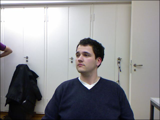

In [23]:
im.to_thumb(160)

In [18]:
# TO generate the pose text file - follow https://oreil.ly/wHL28
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

In [19]:
get_ctr(img_files[0])

tensor([452.3423, 275.7125])

## DataBlock

In [40]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name == '13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

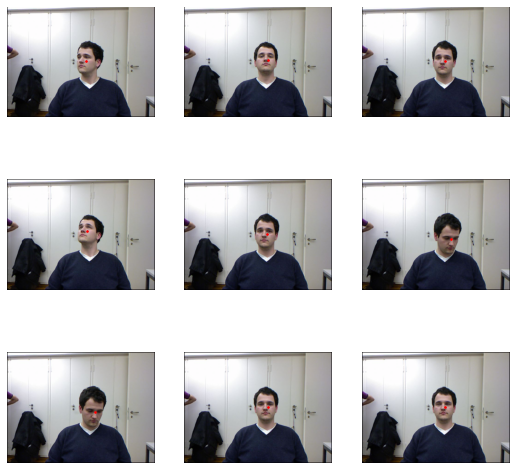

In [41]:
dls = biwi.dataloaders(path)
dls.valid.show_batch()

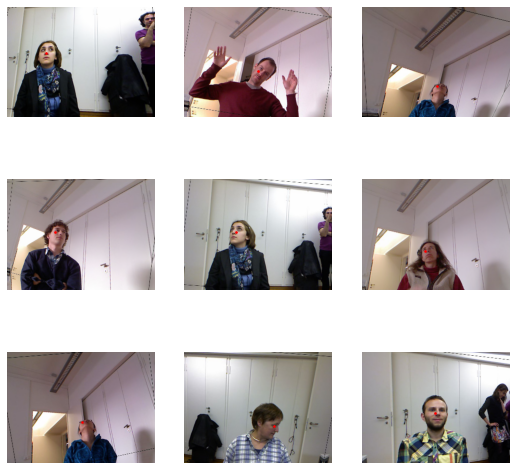

In [42]:
dls.show_batch()

In [43]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [45]:
yb[0]

TensorPoint([[0.0840, 0.2531]], device='cuda:0')

## Training a model

In [46]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [47]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0006918309954926372)

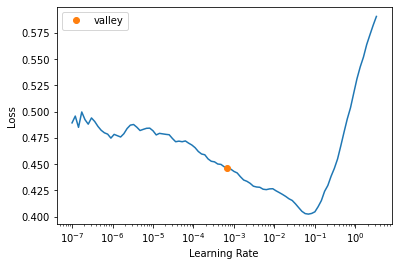

In [48]:
learn.lr_find()

In [ ]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.048114,0.021558,02:54
1,0.006573,0.001320,02:53
2,0.003191,0.000554,02:53
3,0.002082,0.000188,02:54


In [50]:
math.sqrt(0.000188)

0.013711309200802088

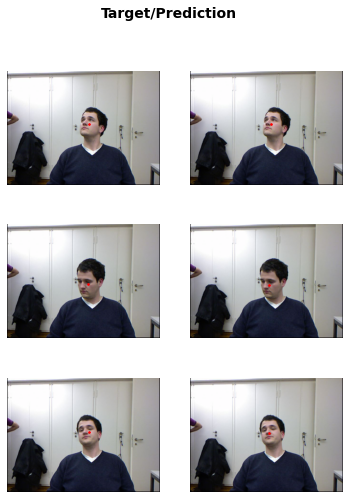

In [51]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))